#GANSPACE - Discovering Interpretable GAN Controls

Using https://github.com/harskish/ganspace to find latent directions in a StyleGAN2 model.

Notebook put together by [@realmeatyhuman](https://twitter.com/realmeatyhuman)




## Setup
Hit play on all the cells below, and everything should run smoothly. The install takes around half a minute.



In [10]:
# Clone git
#git clone https://github.com/harskish/ganspace
%cd ganspace


Cloning into 'ganspace'...
remote: Enumerating objects: 323, done.
remote: Total 323 (delta 0), reused 0 (delta 0), pack-reused 323
Receiving objects: 100% (323/323), 46.79 MiB | 109.14 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/home/tcalo3/projects/project6/src/modules/components/ganspace/ganspace


/home/tcalo3/.pyenv/versions/3.9.16/envs/project6_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!pip install fbpca boto3

# Custom OPs no longer required
#!pip install Ninja
#%cd models/stylegan2/stylegan2-pytorch/op
#!python setup.py install
#!python -c "import torch; import upfirdn2d_op; import fused; print('OK')"
#%cd "/content/ganspace"

In [22]:
import nltk; nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/tcalo3/nltk_data...


True

In [1]:
import sys

sys.path.append('/home/tcalo3/projects/project6/src/modules/components/ganspace')
sys.path.append('/home/tcalo3/projects/project6')

print(sys.path)

['/home/tcalo3/projects/project6/notebooks', '/home/tcalo3/.pyenv/versions/3.9.16/lib/python39.zip', '/home/tcalo3/.pyenv/versions/3.9.16/lib/python3.9', '/home/tcalo3/.pyenv/versions/3.9.16/lib/python3.9/lib-dynload', '', '/home/tcalo3/.pyenv/versions/3.9.16/envs/project6_env/lib/python3.9/site-packages', '/home/tcalo3/projects/project6/src/modules/components/ganspace', '/home/tcalo3/projects/project6']


In [111]:
# Load model
from IPython.utils import io
import torch
import PIL
import numpy as np
import ipywidgets as widgets
from PIL import Image
import imageio
from models import get_instrumented_model
from decomposition import get_or_compute
from config import Config
from skimage import img_as_ubyte
from PIL import Image

# Speed up computation
torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

# Specify model to use
config = Config(
  model='StyleGAN',
  layer='g_mapping.dense7',
  output_class='ffhq',
  components=64,
  use_w=True,
  batch_size=5_000, # style layer quite small
)

inst = get_instrumented_model(config.model, config.output_class,
                              config.layer, torch.device('cuda'), use_w=config.use_w)

path_to_components = get_or_compute(config, inst)

model = inst.model



In [112]:
#@title Load a component at random
path_to_components="/home/tcalo3/projects/project6/src/modules/components/ganspace/cache/components/stylegan-ffhq_g_mapping.dense7_pca-full_c8_n300000_w.npz"
comps = np.load(path_to_components)
lst = comps.files
latent_dirs = []
latent_stdevs = []

load_activations = False

for item in lst:
    if load_activations:
      if item == 'act_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'act_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])
    else:
      if item == 'lat_comp':
        for i in range(comps[item].shape[0]):
          latent_dirs.append(comps[item][i])
      if item == 'lat_stdev':
        for i in range(comps[item].shape[0]):
          latent_stdevs.append(comps[item][i])

#load one at random
num = np.random.randint(8)
random_dir = latent_dirs[num]
random_dir_stdev = latent_stdevs[num]
print(f'Loaded Component No. {num}')


Loaded Component No. 3


In [113]:
from src.modules.metrics.models.facenet import FaceNetModel

In [114]:
def sample_pca_space(n_samples, pca_components, pca_stdevs):
    random_samples = np.random.randn(n_samples, pca_components) * pca_stdevs
    return random_samples

def reconstruct_from_pca(pca_samples, pca_components, data_mean):
    original_data = np.dot(pca_samples, pca_components.T) + data_mean
    return original_data


def project_to_pca(new_data, pca_components, data_mean):
    centered_data = new_data - data_mean
    
    pca_projection = np.dot(centered_data, pca_components)
    return pca_projection



In [115]:
target = model.sample_latent(1, seed=0).cpu().detach().numpy()  # Increment seed for each image
target_out = model.sample_np(target)


In [7]:
w = model.sample_latent(1).cpu().detach().numpy()  # Increment seed for each image
pca_sample = project_to_pca(w,comps['lat_comp'][:,0,:].T,comps['lat_mean'])
reconstructed_sample=reconstruct_from_pca(pca_sample,comps['lat_comp'][:,0,:].T,comps['lat_mean'])
out = model.sample_np(w)


In [8]:
from deepface import DeepFace


2024-05-06 10:28:56.392224: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 10:28:57.371092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
facenet = FaceNetModel()

In [10]:
target = model.sample_latent(1).cpu().detach().numpy()  # Increment seed for each image
target_out = model.sample_np(target)
target_image = Image.fromarray((target_out * 255).astype(np.uint8))
target_resized_image = target_image.resize((160, 160), Image.NEAREST)
target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
target_embedding = facenet(target_tensor.float())

pca_sample = sample_pca_space(1,comps['lat_comp'].shape[0],comps['lat_stdev'] )
X_sample = reconstruct_from_pca(pca_sample,comps['lat_comp'][:,0,:].T,comps['lat_mean'])
X_out = model.sample_np(X_sample.astype(np.float32))
X_image = Image.fromarray((X_out * 255).astype(np.uint8))
X_resized_image = X_image.resize((160, 160), Image.NEAREST)
X_tensor = torch.from_numpy(np.array(X_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
X_embedding = facenet(X_tensor.float())


cosine_similarity = torch.nn.functional.cosine_similarity(target_embedding, X_embedding, dim=1)
l2_distance = torch.nn.functional.pairwise_distance(target_embedding, X_embedding)

l2_distance


tensor([0.3300])

In [116]:
with torch.set_grad_enabled(False):
    facenet = FaceNetModel().eval()
    pass

def train_metric(X,target):
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    target_embedding = facenet(target_tensor.float())

    X_image = Image.fromarray((X_out * 255).astype(np.uint8))
    X_resized_image = X_image.resize((160, 160), Image.NEAREST)
    X_tensor = torch.from_numpy(np.array(X_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    X_embedding = facenet(X_tensor.float())

    return torch.nn.functional.cosine_similarity(target_embedding, X_embedding, dim=1)




In [123]:
target = model.sample_latent(1).cpu().detach().numpy() 
img_target = model.sample_np(target)
train_x = torch.tensor(sample_pca_space(1,comps['lat_comp'].shape[0],comps['lat_stdev'] )).float()
rec_x = reconstruct_from_pca(train_x,comps['lat_comp'][:,0,:].T,comps['lat_mean']).astype(np.float32)
img_x = model.sample_np(rec_x)


In [130]:
mll = ExactMarginalLogLikelihood
fit = fit_gpytorch_mll
gmodel = SingleTaskGP

In [131]:
train_y.shape

torch.Size([1, 1])

In [132]:

train_y_value = train_metric(img_x, img_target)
train_y = torch.tensor([train_y_value], dtype=torch.float32).unsqueeze(-1) # Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
]).float()
with torch.enable_grad():
    gm = gmodel(train_x, train_y)
    mlll = mll(gm.likelihood, gm)
    fit(mlll)



In [142]:

with torch.enable_grad():
    UCB = qUpperConfidenceBound(gm, beta=2)
    candidates, _ = optimize_acqf(
        acq_function=UCB,
        bounds= bounds,
        q=1,  # One new candidate point
        num_restarts=5,
        raw_samples=20  # Initial random points
    )
    rec_x = reconstruct_from_pca(candidates.detach().numpy(),comps['lat_comp'][:,0,:].T,comps['lat_mean']).astype(np.float32)   
    img_x = model.sample_np(rec_x)
    # Evaluate new candidate point
    new_y = train_metric(img_x, img_target)
    new_y_tensor = torch.tensor([new_y], dtype=torch.float32)  # Ensure new_y is 1D
        # Update training data
    train_x = torch.cat([train_x, candidates]).detach()
    train_y = torch.cat([train_y, new_y_tensor.unsqueeze(0)]).detach()




In [87]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound

import warnings
warnings.filterwarnings('ignore')
with torch.set_grad_enabled(False):
    facenet = FaceNetModel().eval()
    pass

def objective_function(X,target):
    target_out = model.sample_np(target)
    target_image = Image.fromarray((target_out * 255).astype(np.uint8))
    target_resized_image = target_image.resize((160, 160), Image.NEAREST)
    target_tensor = torch.from_numpy(np.array(target_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    target_embedding = facenet(target_tensor.float())

    X = reconstruct_from_pca(X,comps['lat_comp'][:,0,:].T,comps['lat_mean'])
    X_out = model.sample_np(X.astype(np.float32))
    X_image = Image.fromarray((X_out * 255).astype(np.uint8))
    X_resized_image = X_image.resize((160, 160), Image.NEAREST)
    X_tensor = torch.from_numpy(np.array(X_resized_image)).unsqueeze(0).permute(0, 3, 1, 2)
    X_embedding = facenet(X_tensor.float())

    return torch.nn.functional.cosine_similarity(target_embedding, X_embedding, dim=1)

target = model.sample_latent(1).cpu().detach().numpy() 


# Generate initial training data
pca_sample = sample_pca_space(1,comps['lat_comp'].shape[0],comps['lat_stdev'] )
train_x = torch.tensor(pca_sample)
train_y = torch.tensor([objective_function(x,target) for x in pca_sample]).unsqueeze(-1)


In [90]:
train_x.shape

torch.Size([1, 8])

In [89]:
# Convert train_x and train_y to float32 or float64 as needed
train_x = train_x.double()  # or train_x.double() for float64
train_y = train_y.double()  # or train_y.double() for float64
with torch.enable_grad():

    gp_model = SingleTaskGP(train_x, train_y)


    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)


    fit_gpytorch_mll(mll)

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])

bounds = bounds.double()

# Define UCB acquisition function
beta = 3  # Adjust beta based on your needs for exploration vs. exploitation

objective_values = []


In [69]:
train_y.shape

torch.Size([1, 1])

In [82]:
new_y.unsqueeze(0)

tensor([[0.9546]], requires_grad=True)

In [86]:
new_y

tensor([0.9546], grad_fn=<SumBackward1>)

In [63]:
# Optimization loop
from tqdm import trange
t = trange(1000, desc='Bar desc', leave=True)

for i in t:
    UCB = qUpperConfidenceBound(gp_model, beta=beta)
    with torch.enable_grad():
        candidates, _ = optimize_acqf(
            acq_function=UCB,
            bounds=bounds,
            q=1,  # One new candidate point
            num_restarts=5,
            raw_samples=20  # Initial random points
        )

        # Evaluate new candidate point
        new_y = objective_function(candidates.detach().numpy(),target)
        objective_values.append(new_y)

        # Update training data
        train_x = torch.cat([train_x, candidates]).detach()
        train_y = torch.cat([train_y, new_y.unsqueeze(0)]).detach()

        # Update the model
        gp_model = SingleTaskGP(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
        fit_gpytorch_mll(mll)
    t.set_description(f"current value {new_y[0]:.2f}")

current value 0.95:   0%|          | 4/1000 [00:02<10:37,  1.56it/s]


KeyboardInterrupt: 

In [61]:
target_out = model.sample_np(target)
target_image = Image.fromarray((target_out * 255).astype(np.uint8))
target_resized_image = target_image.resize((160, 160), Image.NEAREST)

X = reconstruct_from_pca(candidates.detach().numpy(),comps['lat_comp'][:,0,:].T,comps['lat_mean'])
X_out = model.sample_np(X.astype(np.float32))
X_image = Image.fromarray((X_out * 255).astype(np.uint8))
X_image = X_image.resize((160, 160), Image.NEAREST)


In [1]:
display(X_image),display(target_resized_image)

NameError: name 'X_image' is not defined

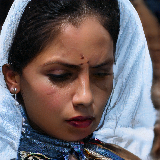

In [63]:
display(target_resized_image)

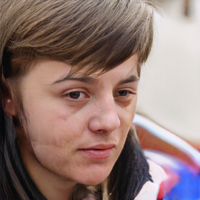

In [128]:

final_im = Image.fromarray((out * 255).astype(np.uint8))
final_im = final_im.resize((200, 200))
display(final_im)

In [104]:
reconstructed_sample=reconstruct_from_pca(pca_sample,comps['act_comp'][:,0,:].T,comps['act_mean'])

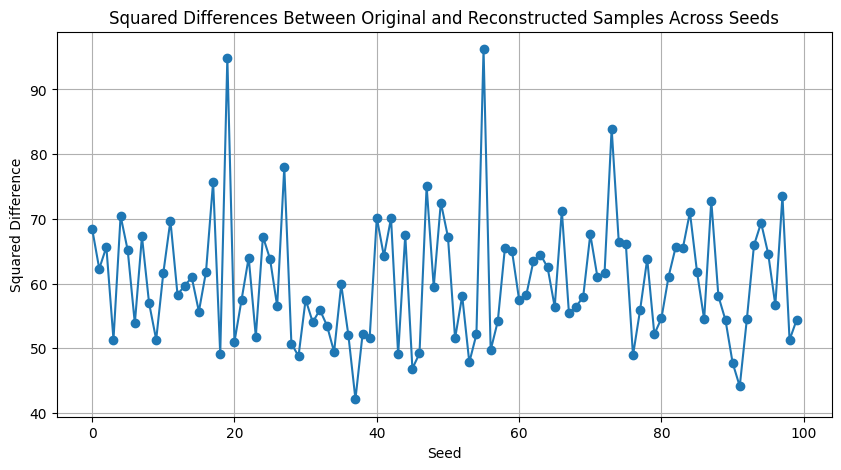

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_square_difference(original, reconstructed):
    """Calculates the squared difference between original and reconstructed samples."""
    return np.sum((original - reconstructed) ** 2)

# Initialize a list to store the squared differences
squared_differences = []

# Assume 'model', 'comps', and necessary functions are already defined
for seed in range(100):
    # Sample latent variables with a different seed each time
    w = model.sample_latent(1, seed=seed).cpu().detach().numpy()  # Sample from the latent space
    
    # Project the sample to PCA space
    pca_sample = project_to_pca(w, comps['act_comp'][:, 0, :].T, comps['act_mean'])
    
    # Reconstruct the sample from PCA space
    reconstructed_sample = reconstruct_from_pca(pca_sample, comps['act_comp'][:, 0, :].T, comps['act_mean'])
    
    # Calculate the square difference
    sq_diff = calculate_square_difference(w, reconstructed_sample)
    squared_differences.append(sq_diff)

# Plotting the squared differences
plt.figure(figsize=(10, 5))
plt.plot(squared_differences, marker='o', linestyle='-')
plt.title('Squared Differences Between Original and Reconstructed Samples Across Seeds')
plt.xlabel('Seed')
plt.ylabel('Squared Difference')
plt.grid(True)
plt.show()

In [40]:
random_pca_sample = sample_pca_space(1, comps['act_comp'].shape[0],comps['act_stdev'])

In [39]:
random_sample=reconstruct_from_pca(random_pca_sample,comps['act_comp'][:,0,:].T,comps['act_mean'])

In [7]:
w = model.sample_latent(1, seed=0).cpu().numpy()

In [8]:
w.shape

(1, 512)

In [ ]:
        w = model.sample_latent(1, seed=seed).cpu().numpy()  # Increment seed for each image
        model.truncation = truncation
        w = [w] * model.get_max_latents()  # one per layer
        for l in range(start, end):
            w[l] = w[l] + direction * (i*current_scale)

        out = model.sample_np(w)
        final_im = Image.fromarray((out * 255).astype(np.uint8))
        final_im = final_im.resize((img_width, img_height))  # Resize each image

In [ ]:

facenet = facenet

    def forward(self, images1, images2):
        # Generate embeddings for both image batches
        embeddings1 = self.facenet(images1)
        embeddings2 = self.facenet(images2)
        # Update state with new cosine similarity value
        self.update(embeddings1, embeddings2)
        return self.cosine_similarity

    def update(self, embeddings1, embeddings2):
        # Compute cosine similarity
        cosine_similarity = torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim=1)
        self.cosine_similarity = cosine_similarity.mean()

    def compute(self):
        # Return the average of the cosine similarity calculated from all updates
        return self.cosine_similarity

In [124]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.monte_carlo import qUpperConfidenceBound

torch.set_grad_enabled(True)  # Context-manager 
import warnings
warnings.filterwarnings('ignore')


def objective_function(pca_parameters,ref):
    # Ensure pca_parameters and ref are numpy arrays
    pca_parameters = np.array(pca_parameters)
    ref = np.array(ref)

    # Compute the dot product
    dot_product = np.dot(pca_parameters, ref)

    # Compute the norms of the vectors
    pca_norm = np.linalg.norm(pca_parameters)
    ref_norm = np.linalg.norm(ref)

    # Avoid division by zero
    if pca_norm == 0 or ref_norm == 0:
        return 0  # Or handle this case in a way that's appropriate for your scenario

    # Calculate cosine similarity
    cosine_similarity = dot_product / (pca_norm * ref_norm)

    # Since optimization typically involves minimization, you might want to minimize 1 - cosine_similarity
    return cosine_similarity

target = torch.rand(len(latent_stdevs))  # 10 initial samples


# Generate initial training data
train_x = torch.rand(5, len(latent_stdevs))  # 10 initial samples

train_y = torch.tensor([objective_function(x.numpy(),target) for x in train_x]).unsqueeze(-1)

# Convert train_x and train_y to float32 or float64 as needed
train_x = train_x.double()  # or train_x.double() for float64
train_y = train_y.double()  # or train_y.double() for float64

gp_model = SingleTaskGP(train_x, train_y)


mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)


fit_gpytorch_mll(mll)

# Define the bounds of your optimization based on PCA variances (assuming normality and using some scale factor)
bounds = torch.stack([
    torch.tensor([-1 * stdev for stdev in latent_stdevs]),  # Lower bounds
    torch.tensor([1 * stdev for stdev in latent_stdevs])   # Upper bounds
])

bounds = bounds.double()

# Define UCB acquisition function
beta = 2.0  # Adjust beta based on your needs for exploration vs. exploitation
UCB = qUpperConfidenceBound(gp_model, beta=beta)






objective_values = []


# Optimization loop
from tqdm import trange
t = trange(1000, desc='Bar desc', leave=True)

for i in t:
    UCB = qUpperConfidenceBound(gp_model, beta=beta)
    candidates, _ = optimize_acqf(
        acq_function=UCB,
        bounds=bounds,
        q=1,  # One new candidate point
        num_restarts=5,
        raw_samples=20  # Initial random points
    )

    # Evaluate new candidate point
    new_y = objective_function(candidates.detach().numpy(),target)
    objective_values.append(new_y)

    # Update training data
    train_x = torch.cat([train_x, candidates.detach()])
    train_y = torch.cat([train_y, torch.tensor([new_y]).double()])

    # Update the model
    gp_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    t.set_description(f"current value {new_y[0]:.2f}")


current value 1.00:   4%|▍         | 38/1000 [00:39<16:42,  1.04s/it]


KeyboardInterrupt: 

In [11]:
# Create an array of iteration numbers
iterations = np.arange(len(objective_values))

# Fit a linear regression model
# Calculate coefficients (slope and intercept)
A = np.vstack([iterations, np.ones(len(iterations))]).T
m, c = np.linalg.lstsq(A, objective_values, rcond=None)[0]

# Create the line of best fit
regression_line = m * iterations + c

# Plotting the objective function values and the regression line
plt.figure(figsize=(5, 2))
plt.plot(iterations, objective_values, 'o', label='Data Points')  # Original data points
plt.plot(iterations, regression_line, 'r', label='Regression Line')  # Regression line
plt.title('Objective Function Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'objective_values' is not defined

In [61]:
# Get new candidate
new_pca_params = candidates.detach()
# Use the new candidate parameters (use them to run more experiments, update model, etc.)
new_objective_value = objective_function(new_pca_params.numpy())

-35.226308339509224

In [198]:
from PIL import Image
from IPython.display import display

def display_sample_pytorch(seed, truncation, direction, distance, scale, start, end, num_images=5, img_width=100, img_height=100):
    images = []  # List to store images
    current_scale = scale  # Start with the initial scale value
    for i in range(num_images):
        w = model.sample_latent(1, seed=seed).cpu().numpy()  # Increment seed for each image
        model.truncation = truncation
        w = [w] * model.get_max_latents()  # one per layer
        for l in range(start, end):
            w[l] = w[l] + direction * (i*current_scale)

        out = model.sample_np(w)
        final_im = Image.fromarray((out * 255).astype(np.uint8))
        final_im = final_im.resize((img_width, img_height))  # Resize each image
        images.append(final_im)  # Append the resized image to the list

    # Create a new blank image to hold all the smaller images
    total_width = img_width * num_images
    composite_image = Image.new('RGB', (total_width, img_height))

    # Paste each image into the composite image
    x_offset = 0
    for im in images:
        composite_image.paste(im, (x_offset, 0))
        x_offset += img_width

    display(composite_image)  # Display the composite image



Distance: -10.00, Scale: 0.01, Direction: 1


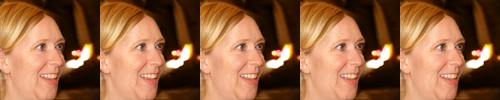

In [245]:
# Random values initialization

seed = np.random.randint(0, 100000)
truncation = 0.7
num = np.random.randint(0, 10)
direction = latent_dirs[5]
scale = 0.01
start_layer = 0
end_layer = model.get_max_latents()  # Assuming your model has a method to retrieve the maximum number of latents
print(f"Distance: {distance:.2f}, Scale: {scale:.2f}, Direction: {num}")
# Display the sample
display_sample_pytorch(seed, truncation, direction, distance, scale, start_layer, end_layer)

From the above analysis can be understood that around a radius of 5 from its center the latent space starts to degrade, we will then focus our reasearch of the 5^(pca_dims) * quants 
where quants can be a discrete step over the pca dimensions which do not causes perceptual difference, we set this step at 0.01


In [175]:
model.get_max_latents()

18